# Chapter 1 - ML Basics Lab — Pandas, Logistic Regression, Decision Trees

**This week's exercise has 4 tasks for a total of 5 points. Every task you need to do from now on will look like this:**

**Task X (Y points)**: Jump up and down 3 times and then print "hello world".

For Programming tasks, code your solutions, test them, and put them on GitHub. To hand them in, demonstrate your solution to a tutor.
For Understanding questions, you can write down your answers to help remember them for the exam, but you don't have to. To hand them in, present them to a tutor.

**Don't forget to commit your solutions to GitHub!**

Before we can dive into modern machine learning and more complicated neural networks, we will explore some of the older machine learning strategies. They are robust, and comparatively easy to understand and implement, but pale in comparison with the performance of modern methods.

- Handling data using Pandas
- Simple data visualizations
- Using and understanding simple ML models like Logistic Regression and Decision Trees in scikit-learn

**Dataset:** As our dataset, we will use the Breast Cancer Wisconsin (Diagnostic) dataset — this is built into `scikit-learn`, with no download needed.  
**Flow:** The order of topics in this notebook looks something like this: Load data → Inspect data → Split data into datasets → Baselines → Logistic Regression → Decision Tree → Comparison → Hyperparameter Tuning.

In [3]:

# === Imports ===
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix,
    RocCurveDisplay, ConfusionMatrixDisplay, PrecisionRecallDisplay, brier_score_loss,
    DetCurveDisplay
)

import matplotlib.pyplot as plt

# Reproducibility
RNG = 42
np.random.seed(RNG)


## Pandas

Pandas is a Python package intended for managing tabular data in an object called a DataFrame. You can think of a DataFrame as kind of similar to a NumPy array or a two-dimensional Dictionary, except with a lot more features - we can sort the entire table by rows or columns very easily, throw out or add rows and columns, etc. etc.

## Load dataset as a pandas DataFrame

The dataset we will work with this week is included in scikit-learn and can therefore be downloaded via the _sklearn.datasets_ functions. We have already imported the necessary function at the start (`from sklearn.datasets import load_breast_cancer`).

The dataset contains information ("features") on cell nuclei present in images taken of fine needle aspirates (FNAs) of breast masses. Our goal will be to use this data later to try and predict whether those masses represent benign growths or tumors, using some older machine learning approaches that are simpler, and more easily explainable, than neural networks.

In [4]:
# Let's first load our data - then, with the help of that data, we will learn to navigate Pandas a little better

data = load_breast_cancer(as_frame=True)
X = data.data.copy()
y = pd.Series(data.target, name="target")  # 0 = malignant, 1 = benign
df = X.join(y)

In [5]:
# df.head() shows us the top part (the "head") of our table
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [6]:
# df.info() shows us some general information on our table
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [7]:
# We can select a single column like we would in a Dict
print(df["mean radius"])

0      17.99
1      20.57
2      19.69
3      11.42
4      20.29
       ...  
564    21.56
565    20.13
566    16.60
567    20.60
568     7.76
Name: mean radius, Length: 569, dtype: float64


In [8]:
# We can also nicely select parts of our table based on some condition.
# For example, we could keep all rows where mean radius is at least 15:
large_radius = df[df["mean radius"] > 15]
print(large_radius.head())
# The syntax for this can be understood as follows:
# My new table (large_radius) is = everywhere in my old table (df) where
# a specific condition (df["mean radius" > 15]) is met.

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   
4        20.29         14.34           135.1     1297.0          0.10030   
6        18.25         19.98           119.6     1040.0          0.09463   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
4           0.13280          0.1980              0.10430         0.1809   
6           0.10900          0.1127              0.07400         0.1794   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

In [9]:
# Similar to a List or Array, we can also iterate over a pandas dataframe:
# For column names:
for col in df:
    print(col)

mean radius
mean texture
mean perimeter
mean area
mean smoothness
mean compactness
mean concavity
mean concave points
mean symmetry
mean fractal dimension
radius error
texture error
perimeter error
area error
smoothness error
compactness error
concavity error
concave points error
symmetry error
fractal dimension error
worst radius
worst texture
worst perimeter
worst area
worst smoothness
worst compactness
worst concavity
worst concave points
worst symmetry
worst fractal dimension
target


In [10]:
# To look at one column only, for example "mean radius":
print(df["mean radius"])

0      17.99
1      20.57
2      19.69
3      11.42
4      20.29
       ...  
564    21.56
565    20.13
566    16.60
567    20.60
568     7.76
Name: mean radius, Length: 569, dtype: float64


In [11]:
# ... and for rows:
for n, row in df.iterrows():
    print(row)
    if n == 3:
        break # We break off the for-loop early, so we don't print at all the rows

mean radius                  17.990000
mean texture                 10.380000
mean perimeter              122.800000
mean area                  1001.000000
mean smoothness               0.118400
mean compactness              0.277600
mean concavity                0.300100
mean concave points           0.147100
mean symmetry                 0.241900
mean fractal dimension        0.078710
radius error                  1.095000
texture error                 0.905300
perimeter error               8.589000
area error                  153.400000
smoothness error              0.006399
compactness error             0.049040
concavity error               0.053730
concave points error          0.015870
symmetry error                0.030030
fractal dimension error       0.006193
worst radius                 25.380000
worst texture                17.330000
worst perimeter             184.600000
worst area                 2019.000000
worst smoothness              0.162200
worst compactness        

In [12]:
# We can also easily add data to a pandas dataframe

shape = df.shape
num_rows, num_columns = shape[0], shape[1]
new_column_name = "example1"
new_column_data = [n for n in range(num_rows)]

# We can manually make new data and add it ...
df[new_column_name] = new_column_data

# ... or with the help of an already existing column
df["example2"] = df["example1"] + 1

In [13]:
# You can see the new columns appended to the end
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,example1,example2
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,0,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,1,2
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,2,3
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,3,4
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,4,5


## Quick exploration of the dataset with pandas

Let us quickly look at our data. How many features, how many examples does it have? Is there a class imbalance? What features do we have available?

In [14]:

print("Shape:", df.shape)
print("\nClass balance:")
print(y.value_counts(normalize=True).rename({0: "malignant", 1: "benign"}))

print("\nDescribe (numeric):")
display(df.describe())


Shape: (569, 33)

Class balance:
target
benign       0.627417
malignant    0.372583
Name: proportion, dtype: float64

Describe (numeric):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,example1,example2
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417,284.000000,285.000000
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918,164.400426,164.400426
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000,0.000000,1.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000,142.000000,143.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000,284.000000,285.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000,426.000000,427.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000,568.000000,569.000000


### Missing values

Sometimes, data can be missing from tables. In this case, the table does not contain a zero or something like that, it contains a "NaN" ("Not a Number"). What is the average of 10, 3, and not a number? Nothing, of course - we can't calculate that. A lot of calculations - and therefore machine learning - is going to break, if we leave these holes in our dataset.

Let's check if there are any missing values in our dataset, using the `.isna()` method.

In [15]:
# Check for NaNs, sum them up, and sort
na_counts = df.isna().sum().sort_values(ascending=False)
# Keep only the parts of the table where we counted at least 1 NaN and print it
print(na_counts[na_counts > 0])


Series([], dtype: int64)


The result is empty, which means there was no place with any NaNs - No missing values, no holes, very good!

### Feature distribution and boxplot by target

To plot some of our features, we use a Python package called matplotlib, which we also already imported at the start (`import matplotlib.pyplot as plt`). To make figures with this package, the path is almost always the same:
- plt.figure() -> This makes a new figure object, into which we can now put stuff.
- "The stuff" -> This is where we actually draw the figure. We can change the labels on the axes (`plt.xlabel()` and `plt.ylabel()`), give the figure a title or subtitle (`plt.title()`), we could put dots into it (`plt.plot(x_coordinates, y_coordinates)`), bars, histograms, etc. etc. etc.
- plt.show() -> This shows the figure and everything we put into it, sort of like print but for plots.

There is a lot of "stuff", and we can't tell you about all of it here, so you will have to search for some of it on the internet yourself. However, everyone uses matplotlib, so you will definitely find functions you need just by googling or going here: https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html

Now, let's look at some feature distributions and our targets a bit more closely. We start by looking at the feature _mean radius_. You can switch features by changing the feature name at the top.

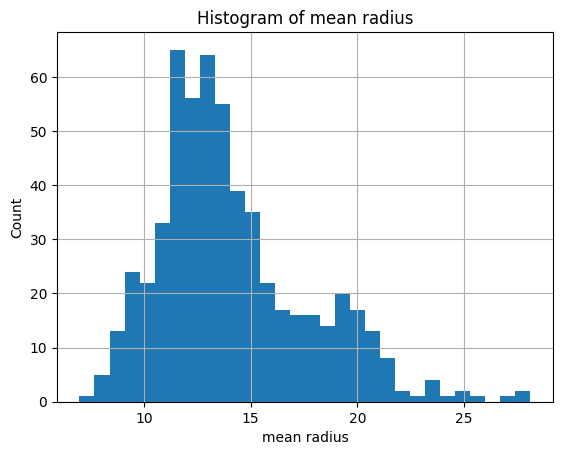

<Figure size 640x480 with 0 Axes>

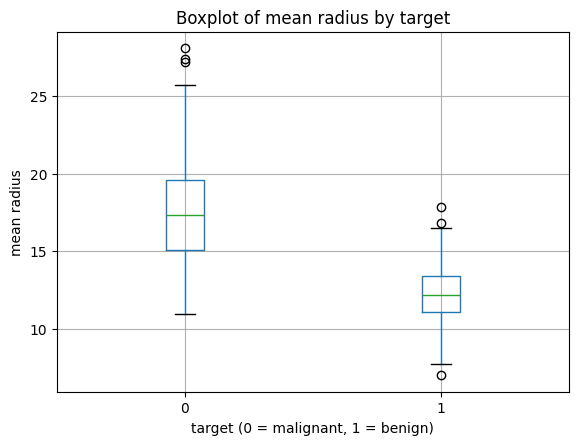

In [16]:

feature = "mean radius"

plt.figure()
X[feature].hist(bins=30)
plt.title(f"Histogram of {feature}")
plt.xlabel(feature)
plt.ylabel("Count")
plt.show()

plt.figure()
df.boxplot(column=feature, by="target")
plt.title(f"Boxplot of {feature} by target")
plt.suptitle("")
plt.xlabel("target (0 = malignant, 1 = benign)")
plt.ylabel(feature)
plt.show()


## Split train/test

Now that we are a little more familiar with the data, let us get to modeling the target. As discussed in the lecture, we need to split the data into train and test data.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RNG
)
print(X_train.shape, X_test.shape)

(426, 30) (143, 30)


## Preprocessing pipelines

The code below performs so-called *preprocessing*. For most datasets in the real world, preprocessing is one of the most important parts of machine learning. Depending on the dataset, task, and exact method of machine learning, preprocessing can include an almost infinite number of things you could do. Specifically for tabular data and older models like we will use today, the steps below are very common:
- Make sure all data has the same data type ("dtype") - if one point of data had a radius of 12 and the other a radius of "dog", the machine learning model would immediately break
- Make sure no data is missing - What is the average of the numbers "1", "2", "3" and "_"? We can't say, we don't know what the empty data point would have been. Our two options are to either replace the data point by inventing a good number - maybe the average, or median, both of which are "2" in this example. Or maybe we randomly pick one of the numbers. The technical term for this replacing/inventing is *Imputation*. Alternatively, we could also say "Maybe I am making a mistake when creating data points like that", and just throw out the missing data point.
- Data normalization - A lot of the time, machine learners normalize their data, which means moving it to within a specific range and shape, typically a uniform distribution from 0 to 1 () or a normal distribution with mean 0 and variance 1. This is done because machine learning models, particularly modern ones, often work best when the input numbers are near zero. We will discuss why this is, when we start working with neural networks. Some examples:
  - Normalization to [0, 1] looks like this:
    
    We start with the values [12, 2, 8, 4]
  - We subtract the minimum (2) -> [10, 0, 6, 2]
  - We divide by the maximum (10) -> [1, 0, 0.6, 0.2]
  - Now all values are in the interval [0, 1]

  - Normalization to a normal gaussian distribution $\mathcal{N}(\mu=0,\sigma=1)$ looks like this:
    
    We start with the same values as before [12, 2, 8, 4]
  - We subtract the mean (6.5) -> [5.5, -4.5, 1.5, -2.5]
  - We divide by the standard deviation (4.435) -> [0.716039, -0.58585, 0.195283, -0.325472]
  - Now the values have roughly 0 mean and variance

All of the features we will use for machine learning today are numerical (numbers such as "1", "2.5", etc.). Categorical features would be something like a column called "names", with entries such as "Alice", "Bob", etc. - you can differentiate between them, but they don't have an obvious way of ordering them in a mathematical sense. The pipeline below contains preprocessing code for both numerical data, as well as categorical data, just in case.



**Task 1 (1 point)**: Why is it potentially bad to impute data points? Do we need data imputation in our pipelines? Explain.

In [18]:

numerical_columns = X.select_dtypes(include=np.number).columns.tolist()
categorical_columns = X.select_dtypes(exclude=np.number).columns.tolist()  # should be empty here

numerical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numerical_pipe, numerical_columns),
    ("cat", categorical_pipe, categorical_columns)
])


## Baseline model: Majority Class

We will now build our first machine learning models. For this week, we will still be using a lot of pre-built pieces that sklearn offers us. Later in the seminar, we will make some much stronger models ourselves, from scratch.

As a simple baseline, we build a _model_ that always predicts the majority class. Any reasonable model should outperform this model by a wide margin, but its a good baseline to have - if your model *doesn't* beat this baseline later on, you know your model or training code is broken.

We make a dummy model, and put it into a dummy pipeline. You can imagine a pipeline as a list of instructions - do this, then that and finally the other things. The fit function in a pipeline optimizes parameters of the model in the pipeline towards some goal or loss function - what it does exactly, we will look at a little later. The predict function takes the input for the model, computes the output and *doesn't* optimize anything.

Our fit and predict functions right now don't do any clever machine learning yet; they only figure out what the most frequently correct answer is, and then "predict" that. In our case, we saw at the start that about 62.9% of our data were benign growth, so the model will predict ONLY benign. If we check the accuracy, it should be almost exactly that percentage (almost because we made random train and test sets).

In [19]:

dummy_pipeline = Pipeline([("pre", preprocess), ("clf", DummyClassifier(strategy="most_frequent", random_state=RNG))])
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)
print("y_pred_dummy:", y_pred_dummy)

# Accuracy baseline
acc_dummy = accuracy_score(y_test, y_pred_dummy)

print(f"Baseline Accuracy: {acc_dummy:.3f}")

y_pred_dummy: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Baseline Accuracy: 0.629


## A Linear Model: Logistic Regression

We now build our first *real* model. We use a linear model with the logistic loss function. This model is called **logistic regression**, because we try to model the *logits*, i.e., the log-odds of the probability that a given input belongs to the positive class.  

Formally, we assume that the log-odds are a linear function of the input features:

$$
\text{logit}(p) = \log\frac{p}{1 - p} = \mathbf{w}^\top \mathbf{x} + b
$$

The logistic (sigmoid) function then maps these logits back to probabilities between 0 and 1:

$$
p = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^\top \mathbf{x} + b)}}
$$

This allows us to perform binary classification by fitting the model parameters $\mathbf{w}$ and $b$ to minimize the logistic loss over the training data.


LogReg Accuracy: 0.986
LogReg F1:       0.989

Classification report (LogReg):
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        53
      benign       0.99      0.99      0.99        90

    accuracy                           0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



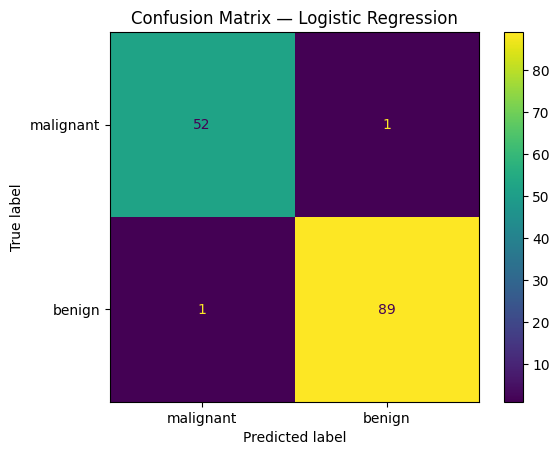

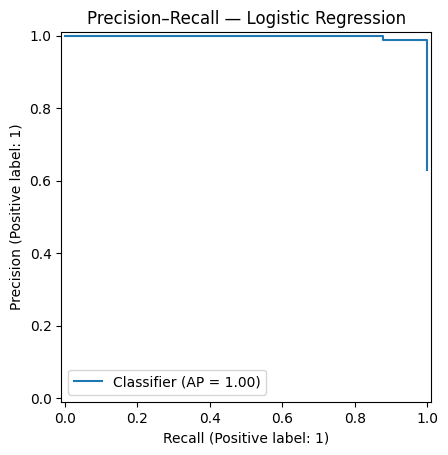

In [20]:
# Like before, we make a pipeline, this time with a different model, the Logistic Regression
logreg = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=RNG))
])

# Like before, we fit and predict
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]

# And now we can check how well we did
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"LogReg Accuracy: {acc_lr:.3f}")
print(f"LogReg F1:       {f1_lr:.3f}")

print("\nClassification report (LogReg):")
print(classification_report(y_test, y_pred_lr, target_names=["malignant", "benign"]))

# We can also plot the Confusion Matrix and our Precision and Recall stats,
# which sklearn can do for us very easily, with classes we have already imported.
# (The plt.figure() part is already taken care of by these classes.)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_lr), display_labels=["malignant","benign"]).plot()
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba_lr)
plt.title("Precision–Recall — Logistic Regression")
plt.show()

## A Non-Linear Model: Decision Tree

Tree Accuracy: 0.923
Tree F1:       0.938

Classification report (Decision Tree):
              precision    recall  f1-score   support

   malignant       0.88      0.92      0.90        53
      benign       0.95      0.92      0.94        90

    accuracy                           0.92       143
   macro avg       0.91      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



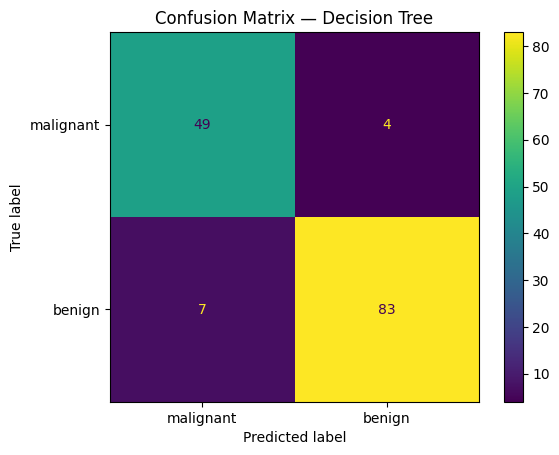

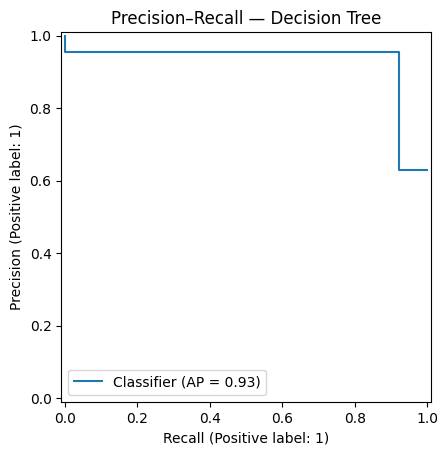

In [21]:

tree = Pipeline([
    ("pre", preprocess),
    ("clf", DecisionTreeClassifier(random_state=RNG))
])
tree.fit(X_train, y_train)

y_pred_dt = tree.predict(X_test)
y_proba_dt = tree.predict_proba(X_test)[:, 1]

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Tree Accuracy: {acc_dt:.3f}")
print(f"Tree F1:       {f1_dt:.3f}")

print("\nClassification report (Decision Tree):")
print(classification_report(y_test, y_pred_dt, target_names=["malignant", "benign"]))

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dt), display_labels=["malignant","benign"]).plot()
plt.title("Confusion Matrix — Decision Tree")
plt.show()


PrecisionRecallDisplay.from_predictions(y_test, y_proba_dt)
plt.title("Precision–Recall — Decision Tree")
plt.show()


## A Tiny Bit of Hyperparameter Tuning

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)

# Logistic Regression grid (accuracy-only)
param_grid_lr = {
    "clf__C": [0.1, 1.0, 10.0]
}
logreg_grid = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=RNG))
])
gs_lr = GridSearchCV(logreg_grid, param_grid_lr, cv=cv, scoring="accuracy", n_jobs=None)
gs_lr.fit(X_train, y_train)
print("Best LogReg params:", gs_lr.best_params_, "CV Accuracy:", round(gs_lr.best_score_, 3))

# Evaluate on test (accuracy)
y_pred_lr = gs_lr.predict(X_test)
print("Test Accuracy (best LogReg):", round(accuracy_score(y_test, y_pred_lr), 3))

# Decision Tree grid (accuracy-only)
param_grid_dt = {
    "clf__max_depth": [3, 5, 10],
    "clf__min_samples_leaf": [1, 5, 20]
}
tree_grid = Pipeline([
    ("pre", preprocess),
    ("clf", DecisionTreeClassifier(random_state=RNG))
])
gs_dt = GridSearchCV(tree_grid, param_grid_dt, cv=cv, scoring="accuracy", n_jobs=None)
gs_dt.fit(X_train, y_train)
print("Best Tree params:", gs_dt.best_params_, "CV Accuracy:", round(gs_dt.best_score_, 3))

# Evaluate on test (accuracy)
y_pred_dt = gs_dt.predict(X_test)
print("Test Accuracy (best Tree):", round(accuracy_score(y_test, y_pred_dt), 3))


Best LogReg params: {'clf__C': 1.0} CV Accuracy: 0.979
Test Accuracy (best LogReg): 0.986
Best Tree params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 5} CV Accuracy: 0.939
Test Accuracy (best Tree): 0.944


**Task 2 (1 point)**: Which model generalized better on this dataset? Elaborate why you think this is the case.

**Task 3 (2 points)**: How do `max_depth` and `min_samples_leaf` change the decision tree's variance? Test this, and summarize your results.

**Task 4 (1 point)**: Inspect the confusion matrices. If the cost of false negatives is high (i.e. we want to avoid them *really strongly*), how would you adjust the threshold? Is there a minimum/maximum to the threshold that you should not adjust it past? Test this, and explain.


# My Answers
**Task 1**

We dont need data inputation, because there is no missing values.

*Why is it bad to inpute data?*

The inpute values dosent represent the true values -> false value influence the model.

**Task 2**

The logistic Regression (Linear Model) generalized better on this Dataset, because the Test Accuracy is higher then the Test Accuracy from the decesion tree.

**Task 3**

With increasing the max_depth the tree becomes more complex and thus the variance also increases.

With more sample_leafes the Variance decrease, because  with more Leafes thhere are more samples and thus the splits are smother.


In [23]:
# ---- Task 3-----
aram_grid_dt = {
    "clf__max_depth": [3, 5, 10],
    "clf__min_samples_leaf": [1, 5, 20]
}
tree_grid = Pipeline([
    ("pre", preprocess),
    ("clf", DecisionTreeClassifier(random_state=RNG))
])
gs_dt = GridSearchCV(tree_grid, param_grid_dt, cv=cv, scoring="accuracy", n_jobs=None)
gs_dt.fit(X_train, y_train)

results = gs_dt.cv_results_


for mean, std, params in zip(results["mean_test_score"], results["std_test_score"], results["params"]):
    print(f"Params: {params} | Mean Accuracy: {mean:.3f} | Variance: {std**2:.6f}")

# Evaluate on test (accuracy)
y_pred_dt = gs_dt.predict(X_test)
print("Test Accuracy (best Tree):", round(accuracy_score(y_test, y_pred_dt), 3))

Params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 1} | Mean Accuracy: 0.939 | Variance: 0.000466
Params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 5} | Mean Accuracy: 0.939 | Variance: 0.000407
Params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 20} | Mean Accuracy: 0.923 | Variance: 0.001250
Params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 1} | Mean Accuracy: 0.927 | Variance: 0.000466
Params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 5} | Mean Accuracy: 0.932 | Variance: 0.000515
Params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 20} | Mean Accuracy: 0.923 | Variance: 0.001250
Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1} | Mean Accuracy: 0.925 | Variance: 0.000259
Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 5} | Mean Accuracy: 0.932 | Variance: 0.000515
Params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 20} | Mean Accuracy: 0.923 | Variance: 0.001250
Test Accuracy (best Tree): 0.944


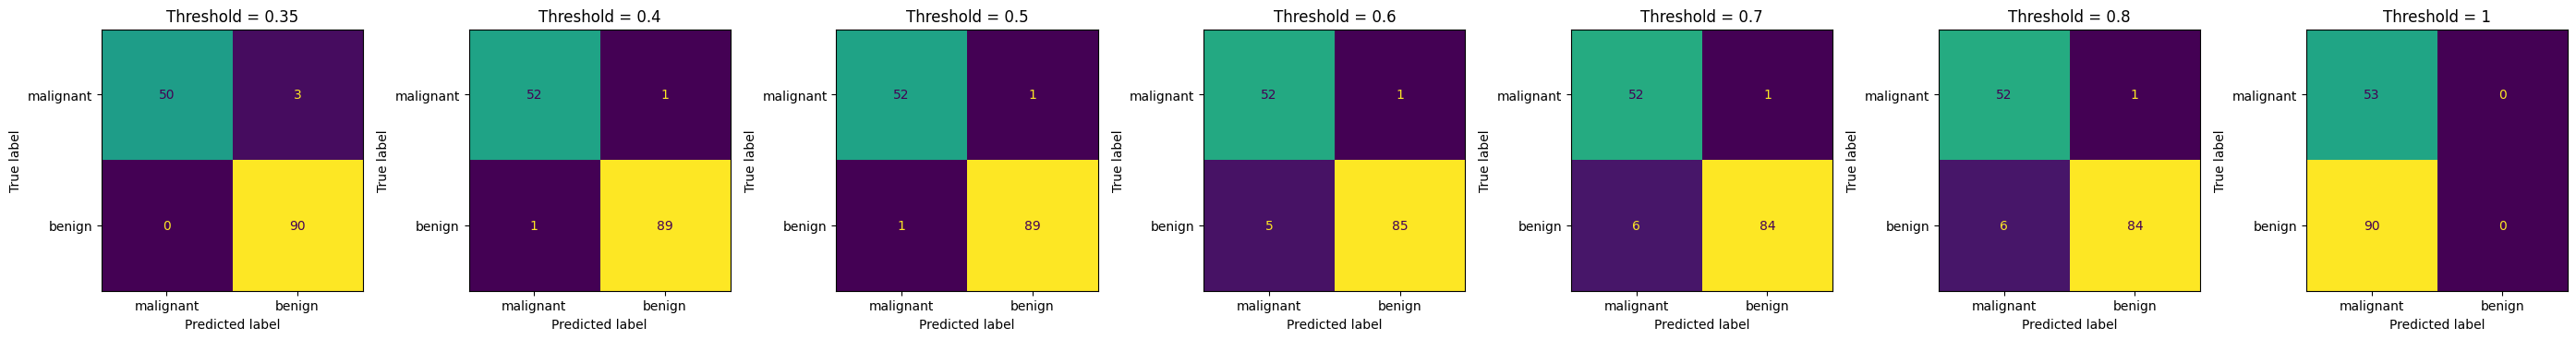

-----------Decision Tree---------------


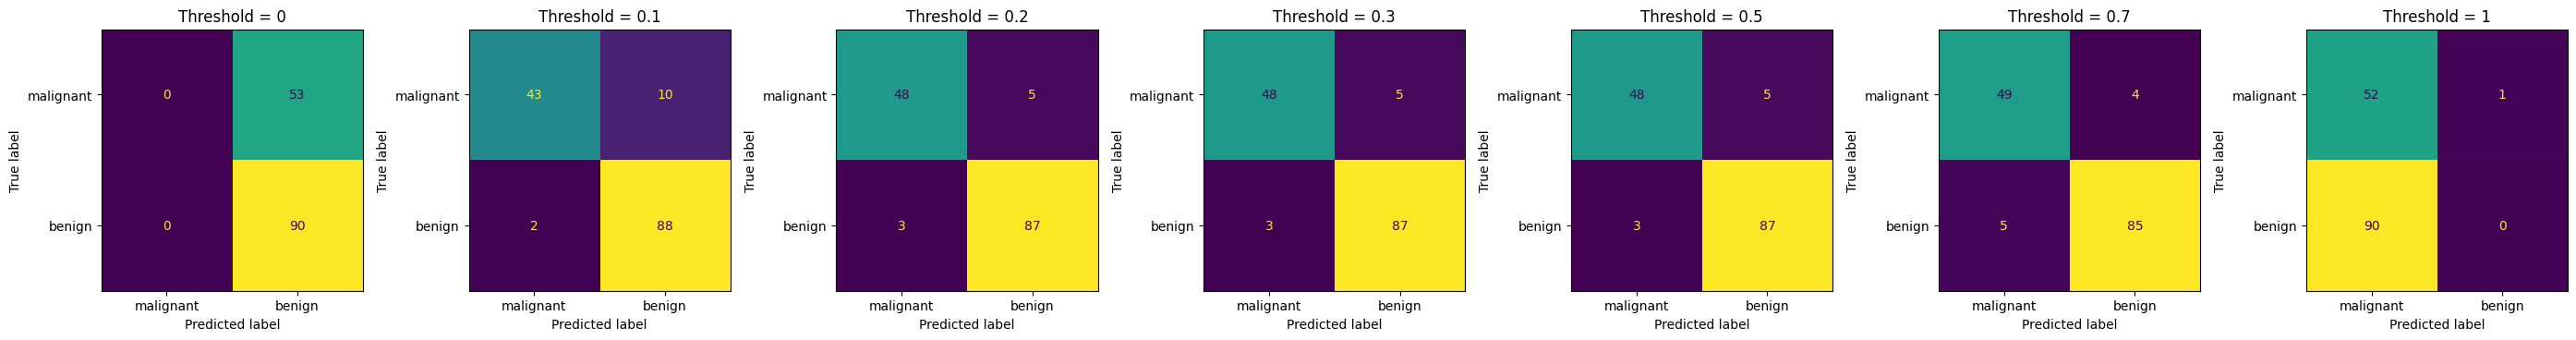

In [42]:

# Task 4 -----LogReg ---------------
logreg = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(C=1.0, max_iter=2000, random_state=RNG))
])

logreg.fit(X_train, y_train)

y_proba_lr = logreg.predict_proba(X_test)[:, 1]

# ----  Thresholds  ----
thresholds = [ 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 1]

fig, axes = plt.subplots(1, len(thresholds), figsize=(4 * len(thresholds), 4))

for ax, thr in zip(axes, thresholds):
    # Schwelle anwenden
    y_pred_thr = (y_proba_lr >= thr).astype(int)

    # Confusion Matrix berechnen
    cm = confusion_matrix(y_test, y_pred_thr)

    # Confusion Matrix zeichnen
    disp = ConfusionMatrixDisplay(cm, display_labels=["malignant", "benign"])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"Threshold = {thr}")

plt.tight_layout()
plt.show()
#-----------------------------------------------------------------------------------
print('-----------Decision Tree---------------')
tree_best = Pipeline([
    ("pre", preprocess),
    ("clf", DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=RNG))
])

tree_best.fit(X_train, y_train)

y_proba_dt = tree_best.predict_proba(X_test)[:, 1]

# ---- Thresholds definieren ----
thresholds = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 1]

fig, axes = plt.subplots(1, len(thresholds), figsize=(4 * len(thresholds), 4))

for ax, thr in zip(axes, thresholds):
    y_pred_thr = (y_proba_dt >= thr).astype(int)

    cm = confusion_matrix(y_test, y_pred_thr)
    disp = ConfusionMatrixDisplay(cm, display_labels=["malignant","benign"])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"Threshold = {thr}")

plt.tight_layout()
plt.show()

**Task 4**
(positiv = malignant)
(FN->bening predicted as malignant)

If FN is high -> lower the threshold

If threshold to low ->  FP increase a bit
---LogReg---

Minimum = 0.4 ; Maximum = 0.5

---Decision Tree---

Minimum = 0.2 ; Maximum 0.5